In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
import multiprocessing 
import pandas as pd
import pyLDAvis
import warnings
import logging
import seaborn
import shutil
import pickle
import gensim
import pprint
import spacy
import time 
import os
import re

%matplotlib inline

## Topic Modeling: Latent Dirichlet Allocation
#### Let's choose the right number of topics for our LDA model using Coherence Scores, then run LDA and visualize it with pyLDAvis.
#### White, Non-White and All-QBs  Separated:
- #### 1. White Quarterbacks
    - 1.1. Preprocessing
    - 1.2. Coherence Scores
    - 1.3. Latent Dirichlet Allocation (LDA)
    - 1.4. Visualizations 
    <br/><br/>
- #### 2. Non-White Quarterbacks
    - 2.1. Preprocessing
    - 2.2. Coherence Scores
    - 2.3. Latent Dirichlet Allocation (LDA)
    - 2.4. Visualizations
    <br/><br/>
- #### 3. All-Quarterbacks
    - 3.1. Preprocessing
    - 3.2. Coherence Scores
    - 3.3. Latent Dirichlet Allocation (LDA)
    - 3.4. Visualizations

In [11]:
pd.set_option('display.max_colwidth', 1000)

# Import our reports
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports.csv'
df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,School,Source,Report
0,Zach Wilson,2021,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...


In [12]:
path = 'dataset-quarterback_stats'
filename = 'census.csv'

# Import info about players ethnicity
df2 = pd.read_csv(os.path.join(path, filename))
df2.head(3)

,Player,Race
0,A.J. Feeley,White
1,A.J. McCarron,White
2,Aaron Brooks,Non-White


In [13]:
# Merge df and df2
df = df.merge(df2, how='left', on='Player')
df = df[['Player', 'Year', 'Race', 'School', 'Source', 'Report']]
df.head(5)

,Player,Year,Race,School,Source,Report
0,Zach Wilson,2021,White,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,White,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,White,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...
3,Zach Wilson,2021,White,BYU,Gamehaus,Wilson rose up draft boards this season more than any other player After his terrific junior season Wilson has elected to declare for the 2021 NFL Draft </p>He was a three-star prospect who had offers from a lot of schools but chose to go to BYU for his college career In his freshman season Wilson played in nine games finishing with 1 578 passing yards 12 touchdowns and three interceptions on 65 9 percent completion The Cougars went 7-6 that season and finished the year with a win in the Famous Idaho Potato Bowl As a sophomore Wilson played in nine games again with 2 382 passing yards 11 touchdowns and nine interceptions on 62 4 percent completion BYU won seven games again during Wilson’s sophomore season Wilson broke out as a junior as he passed for 3 692 yards 33 touchdowns and three interceptions on 73 5 percent completion The Cougars won all but one game during the 2020 season </p>Wilson had a great season for the Cougars and his draft stock went up a lot as a ...
4,Trey Lance,2021,Non-White,North Dakota State,NFL,As a redshirt freshman in 2019 Lance won the Walter Pa

In [14]:
# Split the dataset for white and non-white players
w = df[df['Race'] == 'White'].reset_index(drop=True)
nw = df[df['Race'] == 'Non-White'].reset_index(drop=True)

## 1. White Quarterbacks

In [15]:
# Select white quarterbacks
df = w

### 1.1. Preprocessing

In [16]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
df['Report'] = df['Report'].apply(remove_html_tags)
data = df['Report'].values.tolist()
data_words = list(sent_to_words(data))

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### 1.2. Coherence Scores

In [41]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(1, 7):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=24)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

1 -0.9234904461914661 0.21999993725048256
2 -0.8338224360435949 0.21058667956112553
3 -0.8610247222817181 0.22215256839166075
4 -0.8985201270290307 0.22682300893564894
5 -0.8837930019341418 0.22292537651946082
6 -0.8932982353800085 0.22203572514806938


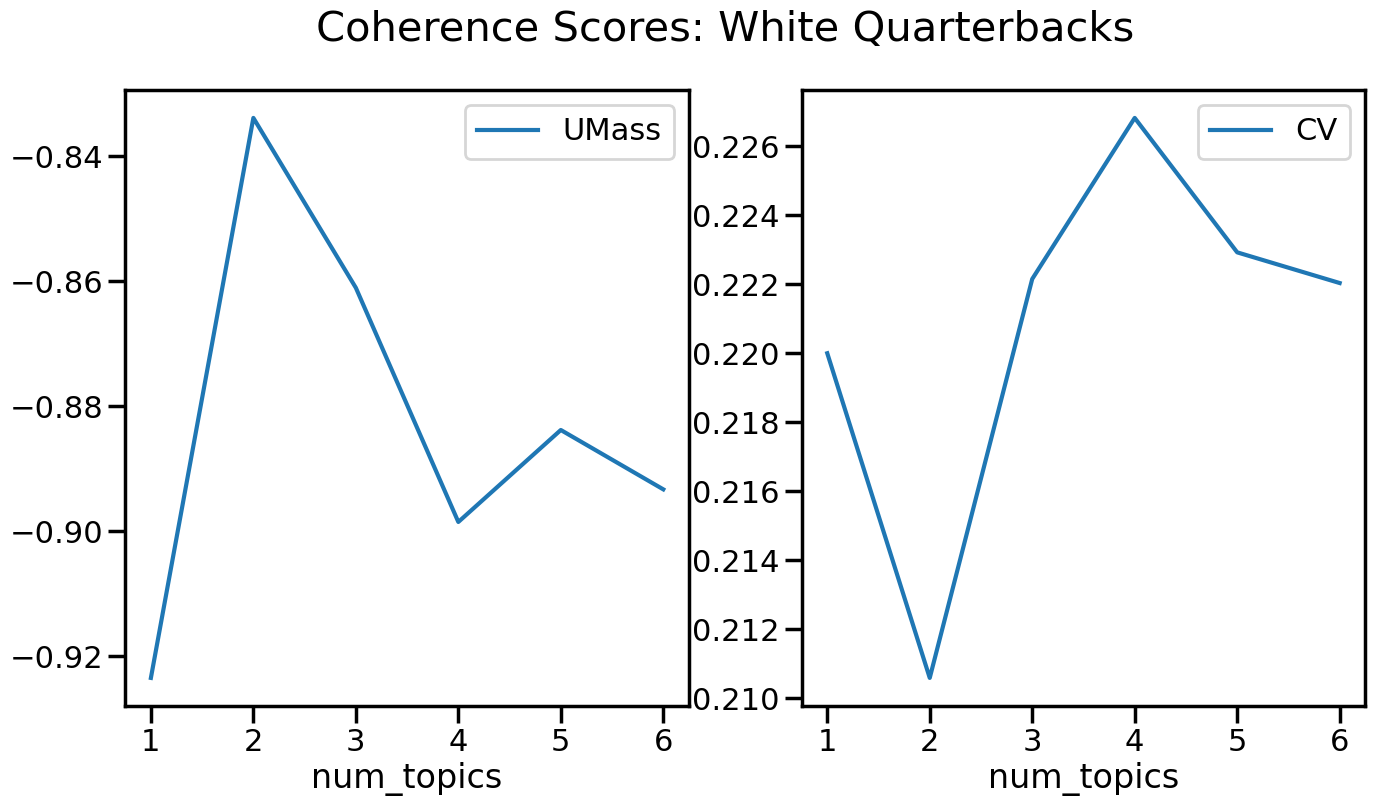

In [43]:
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1, 7))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1, 7))

fig.suptitle("Coherence Scores: White Quarterbacks", fontsize=30)
plt.show()

### 1.3. Latent Dirichlet Allocation (LDA)

In [35]:
# Select number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [36]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_white_qbs'
filename_lda = 'lda_model_white_qbs'
filename_corpus = 'corpus_white_qbs'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [37]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_white_qbs'
filename_lda = 'lda_model_white_qbs'
filename_corpus = 'corpus_white_qbs'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [38]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5046,"yard, game, season, pass, touchdown, interception, start, quarterback, year, team","[throw, nearly, yard, play, defensive, tackle, current, ute, kyle, coach, already, quarterback, ..."
1,1,2,0.9877,"throw, ball, pocket, arm, show, accuracy, strength, time, ability, field","[lean, quarterback, mobility, arm, strength, play, pistol, heavy, offense, byu, feature, full, f..."
2,2,2,0.4479,"throw, ball, pocket, arm, show, accuracy, strength, time, ability, field","[powerful, arm, throw, push, ball, accurate, passer, throw, hard, fastball, tight_window, deep, ..."
3,3,0,0.5281,"yard, game, season, pass, touchdown, interception, start, quarterback, year, team","[rise, draft, board, season, player, terrific, junior, season, elect, declare, nfl, draft, star,..."
4,4,0,0.4791,"yard, game, season, pass, touchdown, interception, start, quarterback, year, team","[break, deshaun, watson, career, pass, yard, pass, touchdown, record, state, title, today, natio..."


In [39]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9904,"yard, game, season, pass, touchdown, interception, start, quarterback, year, team","[put, great, quarterback, recently, fact, put, number, current, crop, well, suit, play, next_lev..."
1,1,0.7232,"quarterback, draft, round, pick, arm, nfl, team, well, college, defense","[arm, strength, quick, release, accurate, thrower, smart, protect, football, intelligent, mature..."
2,2,0.9970,"throw, ball, pocket, arm, show, accuracy, strength, time, ability, field","[play, offense, screen, quick, hitter, half, field, read, ask, full, field, progression, throw, ..."


### 1.4. Visualizations

In [40]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.210064  0.040497       1        1  52.011802
0      0.064310 -0.176923       2        1  32.679758
1      0.145754  0.136426       3        1  15.308441, topic_info=            Term         Freq        Total Category  logprob  loglift
205         yard   895.000000   895.000000  Default  30.0000  30.0000
19          ball  1021.000000  1021.000000  Default  29.0000  29.0000
140  quarterback   810.000000   810.000000  Default  28.0000  28.0000
193    touchdown   528.000000   528.000000  Default  27.0000  27.0000
159       season   638.000000   638.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
392       strong    46.486047   150.360293   Topic3  -5.5058   0.7029
413         year    50.111238   463.034566   Topic3  -5.4307  -0.3468
22           big    46.589966   264.531252   Topic3  -5.5036   0.1402
126       player    45.047286   146.245119   Topic3  -5.5372   0.6992
160       second    44.552495   248.099441   Topic3  -5.5483   0.1596

[204 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.912827   ability
1         3  0.086824   ability
4         1  0.917677  accuracy
4         2  0.081615  accuracy
4         3  0.001991  accuracy
...     ...       ...       ...
413       1  0.116622      year
413       2  0.775320      year
413       3  0.107983      year
747       1  0.992504       zip
747       3  0.005737       zip

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## 2. Non-White Quarterbacks

In [45]:
# Select non-white quarterbacks
df = nw

### 2.1. Preprocessing

In [46]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
df['Report'] = df['Report'].apply(remove_html_tags)
data = df['Report'].values.tolist()
data_words = list(sent_to_words(data))

In [47]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### 2.2. Coherence Scores

In [49]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(1, 7):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=24)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

1 -0.7447050000437221 0.2250616267640429
2 -0.8736953716658542 0.23036321856933828
3 -0.832174594526661 0.23313644583263918
4 -0.8797649103411042 0.23319719170931877
5 -0.8674444885589198 0.2339902234530551
6 -0.7858964600516344 0.23627452003593638


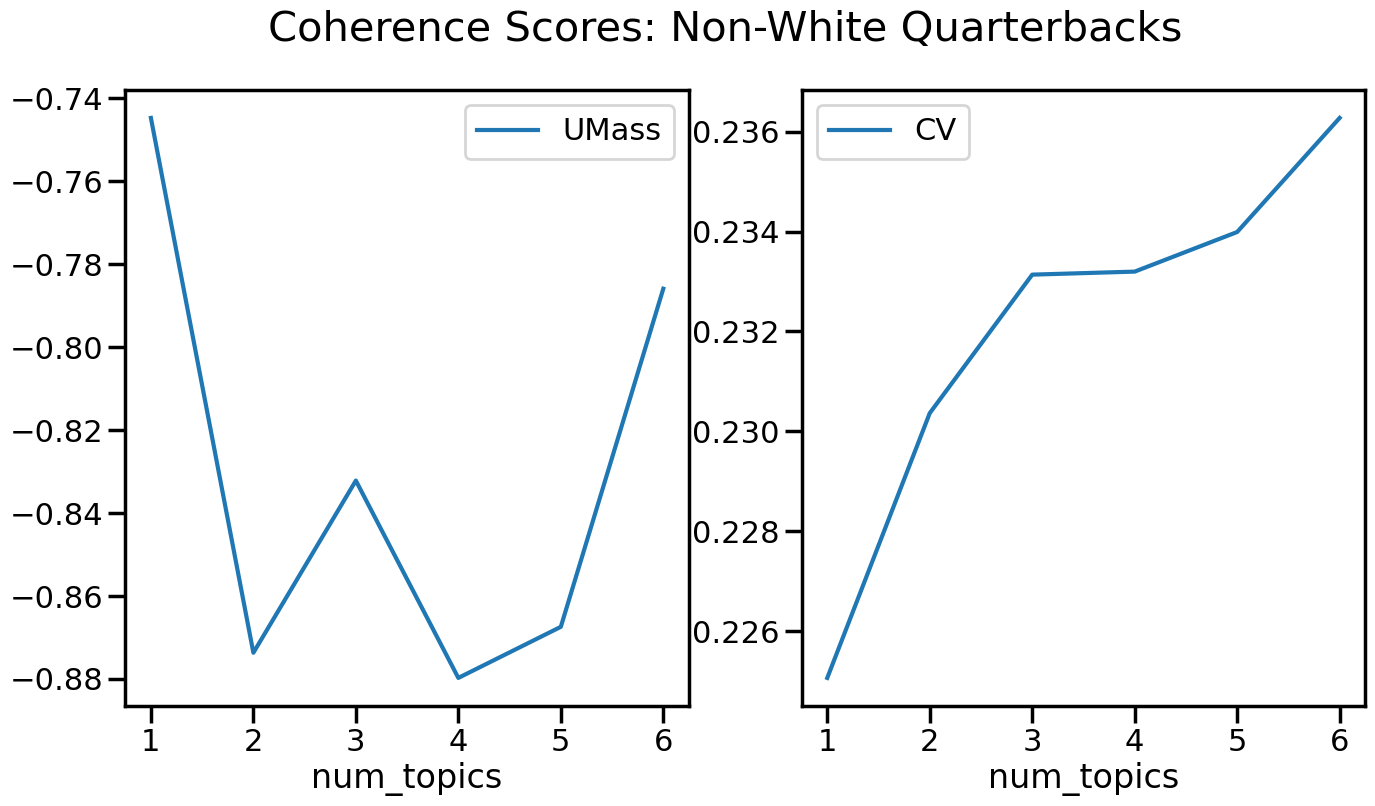

In [57]:
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1, 7))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1, 7))

fig.suptitle("Coherence Scores: Non-White Quarterbacks", fontsize=30)
plt.show()

### 2.3. Latent Dirichlet Allocation (LDA)

In [51]:
# Select number of topics
num_topics = 3

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [52]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_nonwhite_qbs'
filename_lda = 'lda_model_nonwhite_qbs'
filename_corpus = 'corpus_nonwhite_qbs'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [53]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_nonwhite_qbs'
filename_lda = 'lda_model_nonwhite_qbs'
filename_corpus = 'corpus_nonwhite_qbs'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [54]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8698,"throw, ball, pocket, time, arm, ability, play, show, game, field","[lance, top, player, football, championship, subdivision, top, freshman, football, conference, o..."
1,1,1,0.8526,"throw, ball, pocket, time, arm, ability, play, show, game, field","[lance, set, ncaa, record, pass, attempt, complete, season, interception, lead, passer, efficien..."
2,2,1,0.7111,"throw, ball, pocket, time, arm, ability, play, show, game, field","[mond, dual_threat, quarterback, recruit, country, play, teammate, receiver, transfer, senior, s..."
3,3,1,0.9067,"throw, ball, pocket, time, arm, ability, play, show, game, field","[mond, adequate, size, average, physical, ability, excellent, arm, strength, carry, release, qui..."
4,4,1,0.8770,"throw, ball, pocket, time, arm, ability, play, show, game, field","[field, senior, natural, accept, ugas, offer, top, recruit, country, appear, game, true_freshman..."


In [55]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9955,"quarterback, yard, touchdown, team, pass, draft, season, interception, round, game","[young, brother, falcon, qb, rollercoaster, collegiate, career, mar, several, field, issue, marc..."
1,1,0.9974,"throw, ball, pocket, time, arm, ability, play, show, game, field","[highly, competitive, keel, player, rarely, rattled, tape, benefit, spread, uptempo, attack, sim..."
2,2,0.4461,"dixon, tagovailoa, corner, cornerback, tackle, walt, rights_reserve, src_document, mock_draft_no...","[elite, mobility, size, strong, arm, relatively, accurate, hard, bring, leadership, weakness, ma..."


### 3.4. Visualizations

In [56]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.105818  0.128714       1        1  64.285972
0     -0.111574 -0.126462       2        1  32.956180
2      0.217392 -0.002252       3        1   2.757848, topic_info=             Term        Freq       Total Category  logprob  loglift
349     touchdown  228.000000  228.000000  Default  30.0000  30.0000
133   quarterback  368.000000  368.000000  Default  29.0000  29.0000
56          draft  189.000000  189.000000  Default  28.0000  28.0000
762         round  149.000000  149.000000  Default  27.0000  27.0000
180          team  268.000000  268.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
630        choose    2.341668   11.381113   Topic3  -6.0270   2.0096
965        auburn    2.327415   10.952839   Topic3  -6.0332   2.0419
980         cover    2.298903   15.244934   Topic3  -6.0455   1.6989
1085       ponder    2.101714    3.789085   Topic3  -6.1352   3.0013
641          home    2.087459    8.134845   Topic3  -6.1420   2.2305

[194 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
359       1  0.894946   ability
359       2  0.106541   ability
239       1  0.744432  accuracy
239       2  0.254548  accuracy
2         1  0.992680  adequate
...     ...       ...       ...
202       1  0.413805      yard
202       2  0.586435      yard
203       1  0.617086      year
203       2  0.381557      year
1072      2  0.992693     young

[232 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## 3. All-Quarterbacks

In [14]:
pd.set_option('display.max_colwidth', 1000)

# Import our reports
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports.csv'
df = pd.read_csv(os.path.join(path, filename))
df.head(5)

,Player,Year,School,Source,Report
0,Zach Wilson,2021,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...
3,Zach Wilson,2021,BYU,Gamehaus,Wilson rose up draft boards this season more than any other player After his terrific junior season Wilson has elected to declare for the 2021 NFL Draft </p>He was a three-star prospect who had offers from a lot of schools but chose to go to BYU for his college career In his freshman season Wilson played in nine games finishing with 1 578 passing yards 12 touchdowns and three interceptions on 65 9 percent completion The Cougars went 7-6 that season and finished the year with a win in the Famous Idaho Potato Bowl As a sophomore Wilson played in nine games again with 2 382 passing yards 11 touchdowns and nine interceptions on 62 4 percent completion BYU won seven games again during Wilson’s sophomore season Wilson broke out as a junior as he passed for 3 692 yards 33 touchdowns and three interceptions on 73 5 percent completion The Cougars won all but one game during the 2020 season </p>Wilson had a great season for the Cougars and his draft stock went up a lot as a ...
4,Trey Lance,2021,North Dakota State,NFL,As a redshirt freshman in 2019 Lance won the Walter Payton Award as the top player in the Foo

### 3.1. Preprocessing

In [15]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def sent_to_words(sentences):

    for text in sentences:
        text = re.sub(r'class=".*?"', '', text)
        text = re.sub(r'style=".*?"', '', text)
        text = re.sub(r'id=".*?"', '', text)
        text = re.sub(r'of-\d+', '', text)
        text = re.sub(r'\d+-', '', text)
        text = re.sub(r'\d+st', '', text)
        text = re.sub(r'\d+nd', '', text)
        text = re.sub(r'\d+rd', '', text)
        text = re.sub(r'\d+th', '', text) 
        text = re.sub(r'\S*@\S*\s?', '', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = re.sub(r"\'", "", text)       
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)  

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Convert to list
df['Report'] = df['Report'].apply(remove_html_tags)
data = df['Report'].values.tolist()
data_words = list(sent_to_words(data))

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Remove Stopwords, form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### 3.2. Coherence Scores

In [19]:
# To find the best number of topics, we run a "CoherenceModel" with different evaluation scores
coherence_values = []

for num_topics in range(3, 10):
    model = LdaMulticore(corpus=corpus, 
                         id2word=id2word, 
                         num_topics=num_topics, random_state=23)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=data_words, 
                                          dictionary=id2word, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=data_words, 
                                       dictionary=id2word, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

3 -0.9484253409152533 0.24538137374072622
4 -0.8574783402732792 0.23775953934337068
5 -0.9090219642743016 0.24741984928772814
6 -0.8948661933722647 0.2455215930497746
7 -0.8904828957945894 0.24668644986130278
8 -0.9099331904015922 0.2416988360508903
9 -0.8916604203893608 0.2451605218341982


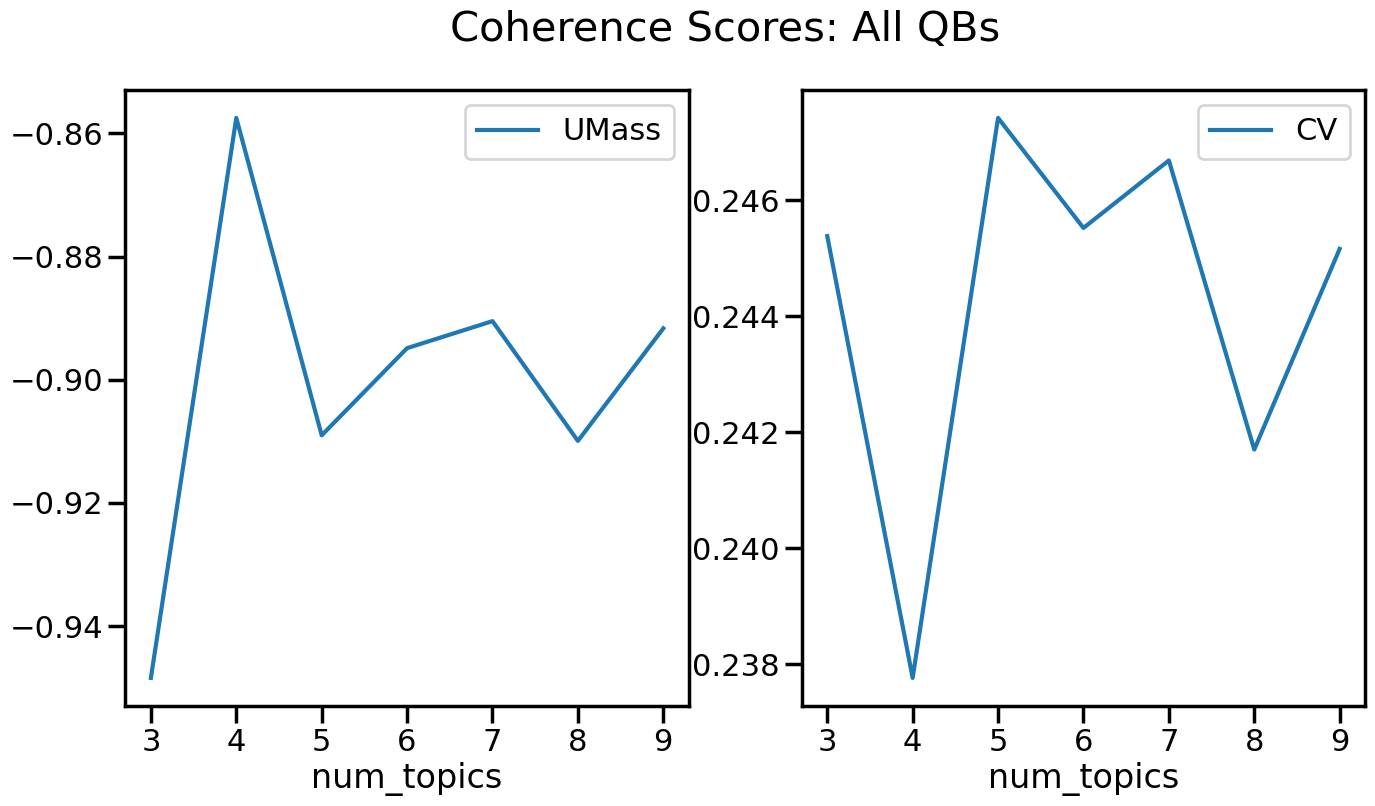

In [20]:
seaborn.set_context('poster') # Use large font

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,10))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,10))

fig.suptitle("Coherence Scores: All QBs", fontsize=30)
plt.show()

### 3.3. Latent Dirichlet Allocation (LDA)

In [21]:
# Select number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,        # Corpus
                                           id2word=id2word,       # Dictionary
                                           num_topics=num_topics, # Number of topics selected 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,          # Chunksize
                                           passes=100,            # Number of passes
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [41]:
### SAVE CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'corpus_overall'

# Create directories to store the model
if os.path.exists(os.path.join(checkpoint, path)):
    shutil.rmtree(os.path.join(checkpoint, path))
    os.mkdir(os.path.join(checkpoint, path))
else:
    os.mkdir(os.path.join(checkpoint, path))

# Let's save a checkpoint of our model and corpus
lda_model.save(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'wb') as f:
    pickle.dump(corpus, f)

In [42]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'corpus_overall'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))
with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

In [43]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

warnings.filterwarnings("ignore", category=FutureWarning) 

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.3811,"adequate, throw, play, pocket, target, int, shoulder, game, release, set","[throw, nearly, yard, play, defensive, tackle, current, ute, kyle, coach, already, quarterback, ..."
1,1,4,0.9106,"throw, ball, show, pocket, arm, ability, strength, time, accuracy, foot","[lean, quarterback, mobility, arm, strength, play, pistol, heavy, offense, byu, feature, full, f..."
2,2,4,0.3895,"throw, ball, show, pocket, arm, ability, strength, time, accuracy, foot","[powerful, arm, throw, push, ball, accurate, passer, throw, hard, fastball, tight_window, deep, ..."
3,3,1,0.4799,"quarterback, arm, draft, season, round, year, first, play, strength, size","[rise, draft, board, season, player, terrific, junior, season, elect, declare, nfl, draft, star,..."
4,4,0,0.5851,"adequate, throw, play, pocket, target, int, shoulder, game, release, set","[lance, top, player, football, championship, subdivision, top, freshman, football, conference, o..."


In [44]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.5851,"adequate, throw, play, pocket, target, int, shoulder, game, release, set","[lance, top, player, football, championship, subdivision, top, freshman, football, conference, o..."
1,1,0.8347,"quarterback, arm, draft, season, round, year, first, play, strength, size","[average, ball, skill, instinct, strong, realize, potential, project, top, corner, class, starte..."
2,2,0.7137,"yard, touchdown, game, pass, interception, season, start, team, complete, throw","[play, game, freshman, completing, attempt, touchdown, interception, hold, role, year, senior, s..."
3,3,0.4777,"quarterback, team, round, pick, draft, ryan, henne, vick, pass, fourth","[strength, quick, release, accurate, thrower, mechanic, field, vision, extremely, mobile, scramb..."
4,4,0.9582,"throw, ball, show, pocket, arm, ability, strength, time, accuracy, foot","[accuracy, touch, average, throw, underneath, sense, timing, lead, receiver, flash, ability, dro..."


### 3.4. Visualizations

In [45]:
warnings.filterwarnings("ignore", category=FutureWarning) 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.248594 -0.088162       1        1  36.294752
1      0.023478  0.016098       2        1  24.819097
0      0.109022  0.119625       3        1  15.884255
2     -0.189223 -0.237474       4        1  14.790843
3     -0.191871  0.189912       5        1   8.211053, topic_info=              Term         Freq        Total Category  logprob  loglift
200           yard  1312.000000  1312.000000  Default  30.0000  30.0000
18            ball  1460.000000  1460.000000  Default  29.0000  29.0000
188      touchdown   758.000000   758.000000  Default  28.0000  28.0000
155         season  1004.000000  1004.000000  Default  27.0000  27.0000
137    quarterback  1214.000000  1214.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
890         backup    42.987076   127.186158   Topic5  -5.3385   1.4149
90    interception    50.657340   628.268487   Topic5  -5.1743  -0.0182
198           work    45.703727   270.628455   Topic5  -5.2772   0.7211
1141      consider    42.838755   145.807782   Topic5  -5.3420   1.2748
292            fit    41.208376   121.531448   Topic5  -5.3808   1.4182

[311 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.998474   ability
4         1  0.693625  accuracy
4         2  0.158814  accuracy
4         3  0.146598  accuracy
1042      4  0.980316    action
...     ...       ...       ...
200       5  0.029716      yard
407       2  0.547397      year
407       3  0.161527      year
407       4  0.290151      year
844       1  0.995147       zip

[401 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])